In [ ]:
import sys
ENABLE_GOOGLE_COLAB = 'google.colab' in sys.modules

In [1]:
if ENABLE_GOOGLE_COLAB:
  # Instalación de API de Google Drive para utilizar archivos en la nube
  !pip install -U -q PyDrive
  # Instala h5py
  !pip install h5py
  # Instala plot.ly
  !pip install plotly
  # TA-Lib: instalación y carga de la librería
  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  !make
  !make install
  !pip install Ta-Lib
  # Instalación de ngrok para visualización en tensorboard
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip
  from google.colab import auth
  from google.colab import files
  
# incluye google drive api
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
import numpy as np

# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

# Librerías de visualización
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')

# TA-Lib: instalación y carga de la librería
import talib

# Otras utilidades
import datetime
import time
import os
import sys

print('Done!')

Using TensorFlow backend.


Done!


In [2]:
# 1. Autenticación en Google Drive
if ENABLE_GOOGLE_COLAB:
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  #2. Obtiene el archivo
  downloaded = drive.CreateFile({'id':'1xuDgK4FteolMBiaYVRNWaofw36iQyRaV'}) # replace the id with id of file you want to access
  downloaded.GetContentFile('EURUSD_M30.csv')  


In [3]:
#3. Carga el archivo en un dataframe
import pandas as pd
eurusd = pd.read_csv('EURUSD_M30.csv', sep=";") 
eurusd.head()


,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD
0,2010.01.04,00:00:00,1.43020,1.44560,1.42570,1.43238,11447,0,20
1,2010.01.04,00:30:00,1.43236,1.43329,1.43151,1.43153,475,0,17
2,2010.01.04,01:00:00,1.43151,1.43153,1.42886,1.43133,1178,0,17
3,2010.01.04,01:30:00,1.43146,1.43149,1.42879,1.42886,920,0,17
4,2010.01.04,02:00:00,1.42885,1.42885,1.42673,1.42796,1036,0,17


In [4]:
# crea una nueva columna de timestamp uniendo date & time y crea columnas para el día de la semana, el día del mes, el mes y la hora del día actual 
df = eurusd.copy()
df['timestamp'] = df['DATE'] + '  ' + df['TIME'] 
df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d %H:%M:%S'))  
df['weekday'] = df['timestamp'].map(lambda x: x.dayofweek) 
df['day'] = df['timestamp'].map(lambda x: x.day) 
df['month'] = df['timestamp'].map(lambda x: x.month) 
df['hhmm'] = df['timestamp'].map(lambda x: x.hour*60 + x.minute) 
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df.head())

         DATE      TIME     OPEN     HIGH      LOW    CLOSE  TICKVOL  VOL  \
0  2010.01.04  00:00:00  1.43020  1.44560  1.42570  1.43238    11447    0   
1  2010.01.04  00:30:00  1.43236  1.43329  1.43151  1.43153      475    0   
2  2010.01.04  01:00:00  1.43151  1.43153  1.42886  1.43133     1178    0   
3  2010.01.04  01:30:00  1.43146  1.43149  1.42879  1.42886      920    0   
4  2010.01.04  02:00:00  1.42885  1.42885  1.42673  1.42796     1036    0   

   SPREAD           timestamp  weekday  day  month  hhmm  
0      20 2010-01-04 00:00:00        0    4      1     0  
1      17 2010-01-04 00:30:00        0    4      1    30  
2      17 2010-01-04 01:00:00        0    4      1    60  
3      17 2010-01-04 01:30:00        0    4      1    90  
4      17 2010-01-04 02:00:00        0    4      1   120  


In [5]:
# obtengo más columnas de entrada
df['returns'] = df['CLOSE'] - df['OPEN']
df['tr'] = df['HIGH'] - df['LOW']
# obtengo columnas de salida a predecir
df['out_open'] = df['OPEN']
df['out_close'] = df['CLOSE']
df.dropna(inplace=True)
df.head()

,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD,timestamp,weekday,day,month,hhmm,returns,tr,out_open,out_close
0,2010.01.04,00:00:00,1.43020,1.44560,1.42570,1.43238,11447,0,20,2010-01-04 00:00:00,0,4,1,0,0.00218,0.01990,1.43020,1.43238
1,2010.01.04,00:30:00,1.43236,1.43329,1.43151,1.43153,475,0,17,2010-01-04 00:30:00,0,4,1,30,-0.00083,0.00178,1.43236,1.43153
2,2010.01.04,01:00:00,1.43151,1.43153,1.42886,1.43133,1178,0,17,2010-01-04 01:00:00,0,4,1,60,-0.00018,0.00267,1.43151,1.43133
3,2010.01.04,01:30:00,1.43146,1.43149,1.42879,1.42886,920,0,17,2010-01-04 01:30:00,0,4,1,90,-0.00260,0.00270,1.43146,1.42886
4,2010.01.04,02:00:00,1.42885,1.42885,1.42673,1.42796,1036,0,17,2010-01-04 02:00:00,0,4,1,120,-0.00089,0.00212,1.42885,1.42796


In [6]:
dfapp = df.copy()
dfapp.drop(columns=['DATE', 'TIME', 'TICKVOL', 'VOL', 'SPREAD'], axis=1, inplace=True)

# reordeno las columnas a mi interés (entradas... salidas...)
dfapp = dfapp[['OPEN','HIGH', 'LOW','CLOSE','returns', 'tr', 'out_open', 'out_close']]
num_outputs = 2
num_inputs = len(dfapp.columns) - num_outputs

print(dfapp.head())

      OPEN     HIGH      LOW    CLOSE  returns       tr  out_open  out_close
0  1.43020  1.44560  1.42570  1.43238  0.00218  0.01990   1.43020    1.43238
1  1.43236  1.43329  1.43151  1.43153 -0.00083  0.00178   1.43236    1.43153
2  1.43151  1.43153  1.42886  1.43133 -0.00018  0.00267   1.43151    1.43133
3  1.43146  1.43149  1.42879  1.42886 -0.00260  0.00270   1.43146    1.42886
4  1.42885  1.42885  1.42673  1.42796 -0.00089  0.00212   1.42885    1.42796


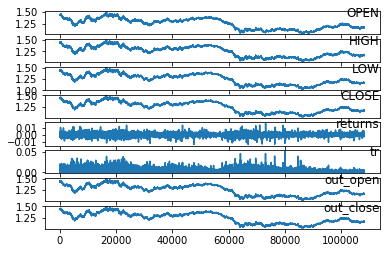

In [9]:
# Visualiza con Matplotlib
# Visualiza 
val = dfapp.values
plt.figure()
for col in range(len(dfapp.columns)):
	plt.subplot(len(dfapp.columns), 1, col+1)
	plt.plot(val[:, col])
	plt.title(dfapp.columns[col], y=0.5, loc='right')
plt.show()

In [10]:
# Creo los scalers de cada columna (entradas y salidas)
values = dfapp.values
values = values.astype('float32')
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
values = scaler.fit_transform(values)

# actualizo el dataframe
df_scaled = pd.DataFrame(data=values, columns=dfapp.columns)
df_scaled.head()

,OPEN,HIGH,LOW,CLOSE,returns,tr,out_open,out_close
0,0.724869,0.788735,0.714753,0.734239,0.079258,-0.228383,0.724869,0.734239
1,0.734310,0.734925,0.740090,0.730525,-0.123777,-0.930981,0.734310,0.730525
2,0.730594,0.727232,0.728533,0.729650,-0.079933,-0.896472,0.730594,0.729650
3,0.730376,0.727056,0.728228,0.718855,-0.243170,-0.895308,0.730376,0.718855
4,0.718969,0.715517,0.719245,0.714922,-0.127825,-0.917798,0.718969,0.714922


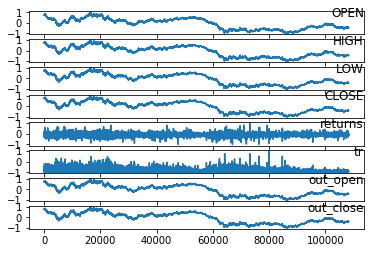

In [11]:
# Visualiza muestras en Matplotlib
plt.figure()
for col in range(len(dfapp.columns)):
	plt.subplot(len(dfapp.columns), 1, col+1)
	plt.plot(values[:, col])
	plt.title(dfapp.columns[col], y=0.5, loc='right')

In [12]:
def series_to_supervised(df, num_inputs, num_outputs, n_in=1, n_out=1, dropnan=True):
  # obtengo el dataframe con las entradas y las salidas
  df_in = df[[x for x in df.columns if df.columns.get_loc(x) < num_inputs]]
  df_out = df[[x for x in df.columns if df.columns.get_loc(x)>=num_inputs]]
  
  cols, names = list(), list()
	# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df_in.shift(i))
    names += [('%s(t-%d)' % (df_in.columns[j], i)) for j in range(0, num_inputs)]
    
	# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):   
    cols.append(df_out.shift(-i))
    if i == 0:
      names += [('%s(t)' % (df_out.columns[j])) for j in range(0, num_outputs)]
    else:
      names += [('%s(t+%d)' % (df_out.columns[j], i)) for j in range(0, num_outputs)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

# Creo columnas para las 24 muestras de entradas t-1, ..., t-48 y para las dos salidas t, t+1
num_in_steps = 24
num_out_steps = 2
sts_df = series_to_supervised(df_scaled, num_inputs, num_outputs, num_in_steps, num_out_steps)
sts_values = sts_df.values
print('Número de muestras total: ', sts_df.shape[0])
sts_df.head()

Número de muestras total:  108263


,OPEN(t-12),HIGH(t-12),LOW(t-12),CLOSE(t-12),returns(t-12),tr(t-12),OPEN(t-11),HIGH(t-11),LOW(t-11),CLOSE(t-11),...,returns(t-2),tr(t-2),OPEN(t-1),HIGH(t-1),LOW(t-1),CLOSE(t-1),returns(t-1),tr(t-1),out_open(t),out_close(t)
12,0.724869,0.788735,0.714753,0.734239,0.079258,-0.228383,0.734310,0.734925,0.740090,0.730525,...,-0.027319,-0.961225,0.719886,0.719887,0.727487,0.719337,-0.073862,-0.952307,0.719362,0.723138
13,0.734310,0.734925,0.740090,0.730525,-0.123777,-0.930981,0.730594,0.727232,0.728533,0.729650,...,-0.073862,-0.952307,0.719362,0.719975,0.728011,0.723138,-0.007083,-0.956185,0.723251,0.724013
14,0.730594,0.727232,0.728533,0.729650,-0.079933,-0.896472,0.730376,0.727056,0.728228,0.718855,...,-0.007083,-0.956185,0.723251,0.724128,0.731978,0.724013,-0.053626,-0.954634,0.724126,0.719249
15,0.730376,0.727056,0.728228,0.718855,-0.243170,-0.895308,0.718969,0.715517,0.719245,0.714922,...,-0.053626,-0.954634,0.724126,0.724477,0.727923,0.719249,-0.140641,-0.915471,0.719362,0.721609
16,0.718969,0.715517,0.719245,0.714922,-0.127825,-0.917798,0.715035,0.712194,0.714710,0.710945,...,-0.140641,-0.915471,0.719362,0.719057,0.724783,0.721609,-0.030691,-0.935634,0.721635,0.715141


In [85]:
def walk_forward(df, wf_train, wf_test, wf_validate):
    values = df.values
    print('Procesando df con {} registros...'.format(values.shape[0]))
    print('walkforward train={}, test={}, validate={}'.format(wf_train, wf_test, wf_validate))
    # calculo el número de muestras del walk-forward (wf_size) en base a los wf de entrenamiento y test
    wf_size = wf_train + wf_test + wf_validate
    # creo arrays para obtener los conjuntos de entranamiento y test
    nd_train=[]
    nd_test=[]
    nd_validate=[]
    # creo un bucle mientras que esté en el rango del número de muestras a procesar
    for i in range(0,values.shape[0],wf_test):
        if i==0:
            nd_train = values[0:wf_train,:]
            nd_test = values[wf_train:wf_train+wf_test,:]  
            nd_validate = values[wf_train+wf_test:wf_size,:]  
            print('Iniciados train.shape={}, test.shape={}, validation.shape={}'.format(nd_train.shape, nd_test.shape, nd_validate.shape))
        # si el punto final de este lote está fuera de rango, lo reajusto y termino
        elif i+wf_size >= values.shape[0]:
            nd_train = np.append(nd_train, values[-wf_size:-(wf_size+wf_train),:] , axis=0)
            nd_test = np.append(nd_test, values[-(wf_size+wf_train):-(wf_size+wf_train+wf_test),:] , axis=0)
            nd_validate = np.append(nd_validate, values[-wf_validate:,:] , axis=0)
            #print('Añadidos train[{},{}] y test[{},{}]'.format(values.shape[0]-wf_size, values.shape[0]-wf_test-1,values.shape[0]-wf_test,values.shape[0]-1))
            break    
        # el resto de casos, se van añadiendo datos a los conjuntos de entrenamiento y test
        else:
            nd_train = np.append(nd_train, values[i:i+wf_train,:] , axis=0)
            nd_test = np.append(nd_test, values[i+wf_train:i+wf_train+wf_test,:] , axis=0)
            nd_validate = np.append(nd_validate, values[i+wf_train+wf_test:i+wf_size,:] , axis=0)
            #print('Añadidos train[{},{}] y test[{},{}]'.format(i,i+wf_train-1,i+wf_train,i+wf_size-1))
    print('train.shape={}, test.shape={}, validate.shape={}'.format(nd_train.shape, nd_test.shape, nd_validate.shape))
    return nd_train,nd_test,nd_validate

  
xdf = sts_df.copy()
wf_size = np.floor(xdf.shape[0]/100)
wf_train = int(np.floor(wf_size * 0.6))
wf_test = int(np.floor(wf_size * 0.2))
wf_validate = int(wf_size - wf_train - wf_test)
train,test,validation = walk_forward(xdf, wf_train, wf_test, wf_validate) 

Procesando df con 1000 registros...
walkforward train=6, test=2, validate=2
Iniciados train.shape=(6, 74), test.shape=(2, 74), validation.shape=(2, 74)
train.shape=(2970, 74), test.shape=(990, 74), validate.shape=(992, 74)


In [86]:
num_train_samples = int(train.shape[0])
num_test_samples = int(test.shape[0])
num_validation_samples = int(validation.shape[0])

# obtengo los pares x-y de cada conjunto
x_train, y_train = train[:,:-(num_outputs * num_out_steps)], train[:,-(num_outputs * num_out_steps):]
x_test, y_test = test[:,:-(num_outputs * num_out_steps)], test[:,-(num_outputs * num_out_steps):]
x_validation, y_validation = validation[:,:-(num_outputs * num_out_steps)], validation[:,-(num_outputs * num_out_steps):]
print('X Train shape:', x_train.shape, ' Y Train shape:', y_train.shape, '\r\n')
print('X Test shape:', x_test.shape, ' Y Test shape:', y_test.shape, '\r\n')
print('X Validation shape:', x_validation.shape, ' Y Validation shape:', y_validation.shape, '\r\n')
print('----------------------------------------------------------------------')

# acondiciono los formatos a la entrada LSTM (num_samples, num_steps, num_features)
x_train = x_train.reshape((x_train.shape[0], num_in_steps, num_inputs))
x_test = x_test.reshape((x_test.shape[0], num_in_steps, num_inputs))
x_validation = x_validation.reshape((x_validation.shape[0], num_in_steps, num_inputs))

print('X Train reshape:', x_train.shape, ' Y Train reshape:', y_train.shape, '\r\n')
print('X Test reshape:', x_test.shape, ' Y Test reshape:', y_test.shape, '\r\n')
print('X Validation reshape:', x_validation.shape, ' Y Validation reshape:', y_validation.shape, '\r\n')

X Train shape: (2970, 72)  Y Train shape: (2970, 2) 

X Test shape: (990, 72)  Y Test shape: (990, 2) 

X Validation shape: (992, 72)  Y Validation shape: (992, 2) 

----------------------------------------------------------------------
X Train reshape: (2970, 12, 6)  Y Train reshape: (2970, 2) 

X Test reshape: (990, 12, 6)  Y Test reshape: (990, 2) 

X Validation reshape: (992, 12, 6)  Y Validation reshape: (992, 2) 



In [87]:
# callback para hacer backup de los pesos en el ordenador local
class DownloadWeights(keras.callbacks.Callback):
  def __init__(self, filepath):
    self.filepath = filepath
  def on_epoch_end(self, epoch, logs={}):
    model_json = self.model.to_json()
    with open("model.json", "w") as json_file:
      json_file.write(model_json)
    # Serializa los pesos a formato HDF5
    self.model.save_weights(self.filepath)
    # Descargo el archivo al ordenador local
    files.download(self.filepath)    
    print("Saved model to disk")
    return
  '''
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    return
  def on_batch_end(self, batch, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  '''

# callback para hacer backup de los pesos en el ordenador local
class FitLogger(keras.callbacks.Callback):
  def __init__(self, fitfile):
    self.fitfile = fitfile
    self.loss, self.val_loss, self.acc, self.val_acc = np.ndarray((0,)), np.ndarray((0,)),np.ndarray((0,)), np.ndarray((0,))
    dfx = pd.DataFrame(data=[[0],[0],[0],[0]]).transpose()
    dfx.columns=['loss','val_loss','acc','val_acc']
    dfx.to_csv(self.fitfile)
    print('file "{}" updated'.format(self.fitfile))

  '''
  def on_epoch_end(self, epoch, logs={}):
    return
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    print('Starting batch...')
    return
  def on_batch_end(self, batch, logs={}):
    print('... batch Finished!')
    return
  def on_epoch_begin(self, epoch, logs={}):
    print('Starting epoch...', epoch)
    return
  '''
  def on_epoch_end(self, epoch, logs={}):
    self.loss = np.append(self.loss, [logs.get('loss')], axis=0)
    self.val_loss = np.append(self.val_loss, [logs.get('val_loss')], axis=0)
    self.acc = np.append(self.acc, [logs.get('acc')], axis=0)
    self.val_acc = np.append(self.val_acc, [logs.get('val_acc')], axis=0)
    s0,s1,s2,s3 = pd.Series(self.loss), pd.Series(self.val_loss), pd.Series(self.acc[-self.loss.shape[0]:]), pd.Series(self.val_acc[-self.loss.shape[0]:])
    dfx = pd.DataFrame(data=[s0,s1,s2,s3]).transpose()
    dfx.columns=['loss','val_loss','acc','val_acc']
    dfx.to_csv(self.fitfile)
    return
  
  

In [88]:
file_weights = "model_weights_ohlc2oc.hdf5"

In [89]:
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

# Crea un modelo LSTM 
def build_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, filepath):
  # Inicio definiendo un modelo secuencial
  model = Sequential()

  sequence_flag = False
  if num_layers > 1:
    sequence_flag = True
    
  # capa de entrada, debe especificar formato 'input_shape'
  model.add(LSTM(num_cells, return_sequences=sequence_flag, input_shape=(num_in_steps, num_inputs)))
  model.add(BatchNormalization())
  model.add(Dropout(0.20))
  
  for i in range(1, num_layers, 1):
    if i == num_layers-1:
      sequence_flag = False
    # capas intermedias
    model.add(LSTM(num_cells, return_sequences=sequence_flag))
    model.add(BatchNormalization())
    model.add(Dropout(0.20))
  
  # la capa de salida es una capa Dense con tantas salidas como timesteps a predecir con activación lineal     
  model.add(Dense(num_outputs * num_out_steps, activation='linear'))

  # compilo con optimizador Adam y pérdida 'mse'
  model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])  

  #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  #download_weights = DownloadWeights(filepath)
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
  fitlogger = FitLogger('fit.csv')
  # callback para visualización en tensorboard
  #tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,write_graph=True,write_grads=True,batch_size=batch_size,write_images=True)
  callbacks_list = [checkpoint, fitlogger]  

  # si existe un modelo previo, lo carga
  try:
    model.load_weights(filepath)
    print('Loaded weights from file: ', filepath)
  except:
    print('No weights file to load')
    
  model.summary()
  return model, callbacks_list

num_cells = 128
num_layers = 6
batch_size = 16
model, callbacks_list = build_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, file_weights)


file "fit.csv" updated
No weights file to load
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 12, 128)           69120     
_________________________________________________________________
batch_normalization_40 (Batc (None, 12, 128)           512       
_________________________________________________________________
dropout_40 (Dropout)         (None, 12, 128)           0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 12, 128)           131584    
_________________________________________________________________
batch_normalization_41 (Batc (None, 12, 128)           512       
_________________________________________________________________
dropout_41 (Dropout)         (None, 12, 128)           0         
_________________________________________________________________
lstm_42 (LSTM)               

In [90]:
# hago un control de epochs manual
epoch_count = 0
#loss, val_loss, acc, val_acc = np.ndarray((0,)), np.ndarray((0,)),np.ndarray((0,)), np.ndarray((0,))

def save_weights(model, filename, notify=False):
  # Serialización del modelo en formato json
  model_json = model.to_json()
  with open("model.json", "w") as json_file:
    json_file.write(model_json)

  # Serializa los pesos a formato HDF5
  model.save_weights(filename)
  if notify:
    print("Saved model to disk")


In [91]:
# Inicia el entrenamiento y validación con los pares de entrenamiento
# para evitar perder los pesos en cierres esporádicos de la conexión del notebook, hago un backup en cada epoch
# de forma manual.
num_epochs = 500
nb_epoch = 500
  
try:
  for i in range(0, num_epochs, nb_epoch):
    print('Iniciando entrenamiento en epoch=',epoch_count)
    history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, callbacks=callbacks_list, validation_data=(x_test,y_test), verbose=2, shuffle=True) 
    num_epochs += nb_epoch
except:
  print('Model fit Exception:', sys.exc_info()[0])

if ENABLE_GOOGLE_COLAB:
  files.download(file_weights)

  


Iniciando entrenamiento en epoch= 0
Train on 2970 samples, validate on 990 samples
Epoch 1/500
 - 15s - loss: 0.7596 - acc: 0.5081 - val_loss: 0.0517 - val_acc: 0.4919
Epoch 2/500
 - 7s - loss: 0.2703 - acc: 0.4929 - val_loss: 0.0073 - val_acc: 0.4990
Epoch 3/500
 - 7s - loss: 0.1628 - acc: 0.5077 - val_loss: 0.0113 - val_acc: 0.5141
Epoch 4/500
 - 7s - loss: 0.1049 - acc: 0.5007 - val_loss: 0.0039 - val_acc: 0.5081
Epoch 5/500
 - 7s - loss: 0.0653 - acc: 0.5121 - val_loss: 0.0050 - val_acc: 0.5071
Epoch 6/500
 - 7s - loss: 0.0434 - acc: 0.5071 - val_loss: 4.4670e-04 - val_acc: 0.5051
Epoch 7/500
 - 7s - loss: 0.0286 - acc: 0.5044 - val_loss: 0.0016 - val_acc: 0.4970
Epoch 8/500
 - 7s - loss: 0.0199 - acc: 0.4960 - val_loss: 0.0026 - val_acc: 0.4980
Epoch 9/500
 - 7s - loss: 0.0147 - acc: 0.5108 - val_loss: 0.0044 - val_acc: 0.4980
Epoch 10/500
 - 7s - loss: 0.0105 - acc: 0.5125 - val_loss: 3.9431e-04 - val_acc: 0.5081
Epoch 11/500
 - 7s - loss: 0.0077 - acc: 0.5064 - val_loss: 0.0014 

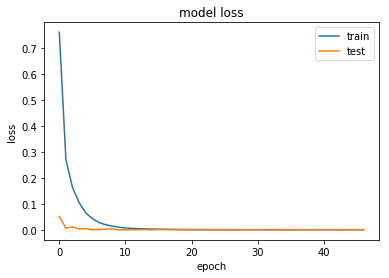

In [92]:
plt.plot(callbacks_list[1].loss[:])
plt.plot(callbacks_list[1].val_loss[:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
epoch_count += num_epochs

In [16]:
# Evalúa el funcionamiento con la partición de evaluación
  scores = model.evaluate(x_validation, y_validation, verbose=2)
  print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Accuracy: 30.68%


In [93]:
# Pruebas de visualización de resultados. Preparación de datos
sample = 0
x_data = x_test
y_data = y_test 


In [154]:
import math

def recover_data_scale(scaler, data, is_output):
  a = np.asarray(data)
  if is_output:
    a = np.insert(a, 0, np.zeros(num_inputs))
  else:
    a = np.append(a, np.zeros(num_outputs))
  a=a.reshape(1,a.shape[0])
  a=scaler.inverse_transform(a)
  if is_output:
    a = a[0, -num_outputs:]
  else:
    a = a[0,:num_inputs]    
  return a

# Realizo predicción del primer conjunto de datos
x = x_data[sample].reshape(1, num_in_steps, num_inputs)
y = y_data[sample].reshape(1,num_outputs * num_out_steps)
predictions = model.predict(x, batch_size=1,verbose=0)

predictions = recover_data_scale(scaler, predictions, True)
target = recover_data_scale(scaler, y[0,:], True)

# Calculo el error RMSE
rmse = math.sqrt(sk.mean_squared_error(target, predictions, multioutput = 'uniform_average'))
print('RMSE: %f' % rmse)

sample += 1

"""
# Visualización de muestra 'sample' sólo tomo los datos de interes, es decir los datos relativos a CLOSE  t-1,.. t-n
name_to_search = 'CLOSE(t'
sample_values = np.ndarray((0,))
# input sequence (t-n, ... t-1)
for i in range(num_inputs*num_in_steps):
  if name_to_search in sts_df.columns[i]: 
    sample_values = np.append(sample_values, x[0,:,sts_df.columns.get_loc(sts_df.columns[i])], axis=0)
    break        
plt.plot(sample_values, marker='o', color='b')
name_to_search = 'OPEN(t'
sample_values = np.ndarray((0,))
# input sequence (t-n, ... t-1)
x = x_data[sample].reshape(1, num_in_steps, num_inputs)
for i in range(num_inputs*num_in_steps):
  if name_to_search in sts_df.columns[i]: 
    sample_values = np.append(sample_values, x[0,:,sts_df.columns.get_loc(sts_df.columns[i])], axis=0)
    break        
plt.plot(sample_values, marker='o', color='g')

# Visualizo salida esperada
p = np.arange(num_in_steps, num_in_steps+num_out_steps)
for i in range(num_outputs):
  plt.plot(p, y[0,sample,i], marker='o', color='r')
"""

RMSE: 0.002623


"\n# Visualización de muestra 'sample' sólo tomo los datos de interes, es decir los datos relativos a CLOSE  t-1,.. t-n\nname_to_search = 'CLOSE(t'\nsample_values = np.ndarray((0,))\n# input sequence (t-n, ... t-1)\nfor i in range(num_inputs*num_in_steps):\n  if name_to_search in sts_df.columns[i]: \n    sample_values = np.append(sample_values, x[0,:,sts_df.columns.get_loc(sts_df.columns[i])], axis=0)\n    break        \nplt.plot(sample_values, marker='o', color='b')\nname_to_search = 'OPEN(t'\nsample_values = np.ndarray((0,))\n# input sequence (t-n, ... t-1)\nx = x_data[sample].reshape(1, num_in_steps, num_inputs)\nfor i in range(num_inputs*num_in_steps):\n  if name_to_search in sts_df.columns[i]: \n    sample_values = np.append(sample_values, x[0,:,sts_df.columns.get_loc(sts_df.columns[i])], axis=0)\n    break        \nplt.plot(sample_values, marker='o', color='g')\n\n# Visualizo salida esperada\np = np.arange(num_in_steps, num_in_steps+num_out_steps)\nfor i in range(num_outputs):\n 

Text(0.5, 1.0, 'EURUSD OHLC en M30')

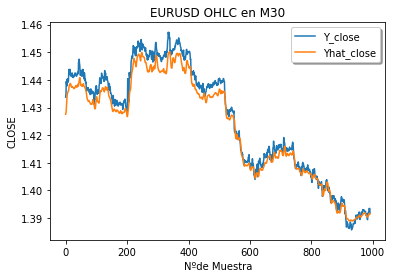

In [159]:
# Una vez validado, realiza las predicciones con las entradas de validación, visualiza y obtiene error
x_eval = x_validation
y_eval = y_validation
yhat = np.ndarray(shape=y_eval.shape)
y = np.ndarray(shape=y_eval.shape)
for i in range(x_eval.shape[0]):
  x = x_eval[i]
  x = x.reshape(1, num_in_steps, num_inputs)
  y[i] = recover_data_scale(scaler, y_eval[i], True)
  predictions = model.predict(x, batch_size=1, verbose=0)
  yhat[i] = recover_data_scale(scaler, predictions, True)

# creo array de resultados, deshago inversión  
yresult = np.ndarray(shape=y.shape)
yresult[:,0] = y[:,0]
yresult[:,1] = yhat[:,0]
 
# visualizo los resultados
plt.plot(yresult[:,0])
plt.plot(yresult[:,1])
#plt.plot(y[:,0])
#plt.plot(yhat[:,0])
plt.xlabel('Nºde Muestra')
plt.ylabel('CLOSE')
plt.legend(('Y_close','Yhat_close'), loc='upper right', shadow=True)
plt.title('EURUSD OHLC en M30') 
    
